In [1]:
####
# Creator;Maintainer: Tamas Szuromi - tromika@gmail.com
####

In [242]:
# Dependency load

In [59]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lifetimes import BetaGeoFitter, ModifiedBetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data

In [133]:
data = pd.read_csv("../data/raw/training.csv")

In [3]:
data.columns.values

array(['order_id', 'contact_id', 'purchase_date', 'product_id', 'quantity',
       'sales_amount'], dtype=object)

In [26]:
data.dtypes

order_id                  int64
contact_id                int64
purchase_date    datetime64[ns]
product_id                int64
quantity                  int64
sales_amount            float64
dtype: object

In [134]:
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

In [27]:
data.head()

,order_id,contact_id,purchase_date,product_id,quantity,sales_amount
0,4852169,17846335,2012-01-01,3308032,1,18.71
1,3570597,18759585,2012-01-01,37220513,2,83.50
2,32096674,5025194,2012-01-01,10259603,1,19.95
3,2904402,29624779,2012-01-01,3308032,1,18.71
4,38369470,42287117,2012-01-01,3308032,1,18.71


In [245]:
# Keep it simple I took the outlier filtering from R manually
# Have to merge orders for the model input

In [135]:
dataFiltered = data[(data.sales_amount>0) & (data.sales_amount<=np.percentile(data['sales_amount'],[99.995])[0]) & (data.quantity<=np.percentile(data['quantity'],[99.99])[0]) ]
inputData = dataFiltered.groupby(['contact_id', 'order_id']).agg({'sales_amount': np.sum, 'purchase_date':'first'}).reset_index()

In [94]:
inputData.head()

,contact_id,order_id,purchase_date,sales_amount
0,22,20931901,2012-01-03,27.45
1,445,36058004,2012-11-22,131.85
2,665,15515069,2013-06-06,309.47
3,734,30699049,2013-05-07,69.90
4,884,2789595,2013-03-21,254.85


In [205]:
# For the MBG/NBD model we have to transform the data and get the freq, recency, customers' age and the sales amounts
trainingSet = summary_data_from_transaction_data(inputData, 
                                                 'contact_id',
                                                 'purchase_date',
                                                 monetary_value_col= 'sales_amount',
                                                 freq='M',
                                                 observation_period_end='2013-12-31')

In [31]:
trainingSet.columns.values

array(['frequency', 'recency', 'T', 'monetary_value'], dtype=object)

In [233]:
# The best goodness of fit was achived with the ModifiedBetaGeoFitter on monthly basis
# In the task desc I only saw monthly validation so it's aligned.
# The model for high nb of transactions was a bit overfitted so it was corrected with the penalizer_coef
# It will be used to predict the future transactions

mbgf = ModifiedBetaGeoFitter(penalizer_coef=0.0001)
mbgf.fit(trainingSet['frequency'], trainingSet['recency'], trainingSet['T'])
print bgf

<lifetimes.ModifiedBetaGeoFitter: fitted with 262264 subjects, a: 0.81, alpha: 7.20, b: 0.68, r: 0.59>


In [ ]:
############
#More info about the best performing model:
############
# Also known as the MBG/NBD model. Based on [1,2], this model has the following assumptions:
#    1) Each individual, i, has a hidden lambda_i and p_i parameter
#    2) These come from a population wide Gamma and a Beta distribution respectively.
#    3) Individuals purchases follow a Poisson process with rate lambda_i*t .
#    4) At the beginning of their lifetime and after each purchase, an individual has a
#       p_i probability of dieing (never buying again).
#    [1] Batislam, E.P., M. Denizel, A. Filiztekin (2007),
#        "Empirical validation and comparison of models for customer base analysis,"
#        International Journal of Research in Marketing, 24 (3), 201-209.
#    [2] Wagner, U. and Hoppe D. (2008), "Erratum on the MBG/NBD Model," International Journal
#        of Research in Marketing, 25 (3), 225-226.

In [ ]:
# I keep some validation

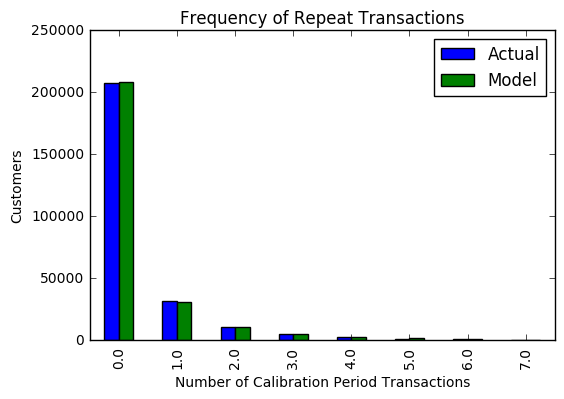

In [146]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

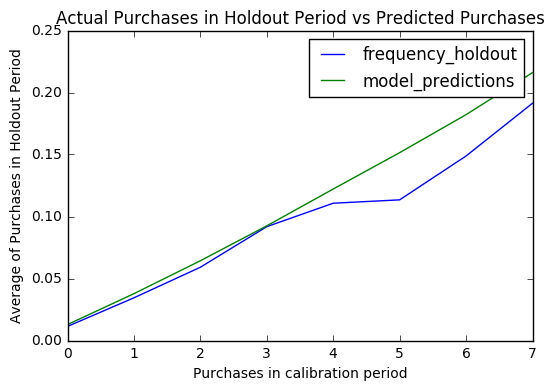

In [237]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.utils import calibration_and_holdout_data

cv = calibration_and_holdout_data(data, 'contact_id', 'purchase_date', 
                                        calibration_period_end='2013-11-30',
                                        observation_period_end='2013-12-31', 
                                        freq='M' )   
mbgfVal = ModifiedBetaGeoFitter(penalizer_coef=0.0001)
mbgfVal.fit(cv['frequency_cal'], cv['recency_cal'], cv['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(mbgfVal, cv)

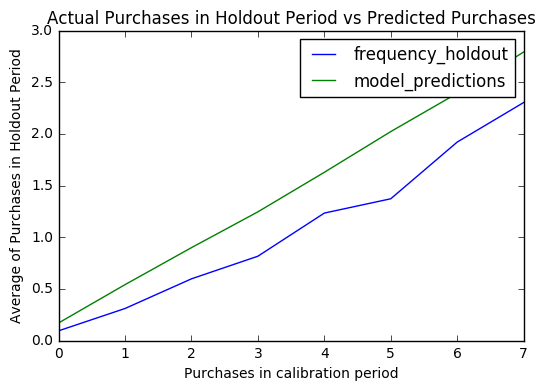

In [241]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.utils import calibration_and_holdout_data

cv = calibration_and_holdout_data(data, 'contact_id', 'purchase_date', 
                                        calibration_period_end='2013-03-31',
                                        observation_period_end='2013-12-31', 
                                        freq='M' )   
mbgfVal = ModifiedBetaGeoFitter(penalizer_coef=0.0001)
mbgfVal.fit(cv['frequency_cal'], cv['recency_cal'], cv['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(mbgfVal, cv)

In [234]:
# This modell will be used to predict the avarage sales amount

from lifetimes import GammaGammaFitter

ReturningtTrainingSet = trainingSet[trainingSet['frequency']>0]
ggf = GammaGammaFitter(penalizer_coef=0.0001)
ggf.fit(ReturningtTrainingSet['frequency'],
        ReturningtTrainingSet['monetary_value'])
print ggf  

<lifetimes.GammaGammaFitter: fitted with 49154 subjects, p: 8.00, q: 1.87, v: 11.86>


In [ ]:
############
# More info about the Gamma Gamma model
###########
#    Fitter for the gamma-gamma model, which is used to estimate the average monetary value of customer transactions.
#    This implementation is based on the Excel spreadsheet found in [1]. More details on the derivation and evaluation
#    can be found in [2].
#    [1] http://www.brucehardie.com/notes/025/
#    [2] Peter S. Fader, Bruce G. S. Hardie, and Ka Lok Lee (2005), "RFM and CLV: Using iso-value curves for customer
#        base analysis", Journal of Marketing Research, 42 (November), 415-430

In [240]:
predPeriod = 12
monetaryPerTransaction = ggf.conditional_expected_average_profit(
        trainingSet['frequency'],
        trainingSet['monetary_value']
    ).mean()

predTransactions = mbgf.conditional_expected_number_of_purchases_up_to_time(predPeriod,
        trainingSet['frequency'],
        trainingSet['recency'],
        trainingSet['T']).sum()

print "Predicted sales amount per transactions: %s, Predicted transactions: %s, Predicted sales amount: %s " % (
    monetaryPerTransaction,
    predTransactions,
    predTransactions*monetaryPerTransaction
)

Predicted sales amount per transactions: 106.545329023, Predicted transactions: 58672.7147293, Predicted sales amount: 6251303.69551 
